In [3]:
using DifferentialEquations
using Plots

pyplot()

Plots.PyPlotBackend()

Ниже **явная разностная схема**

Опишу все переменные по порядку:
 - startcond, bordcond задают начальные и граничные условия, почему они так выглядят - хз, но в интернетах пишут, что они выглядт так + ничего о адибатических условиях граничных я не в интернете не нашел
  - D(u) коэффициент теплопроводности, поставил единицу(а почему бы и нет)
   - Nx, Nt задают количество узлов, из них получаем размеры сетки и соответвественно размер коэффициента $\kappa*\frac{\Delta{t}}{\Delta{x}^2}$
   - U массив значений температур в разнух узлах сетки
Теперь графики:
 - Первый график показывает сравнение темеператур в как менялась температура на разно расстоянии в разные моменты времени(1 шаг, 10 шаг, 40 шаг). По оси абсцисс - расстоянии, по оси ординат - температура
  - Второй график показывает по сути распространение тепла, (так и называется *heatmap*)

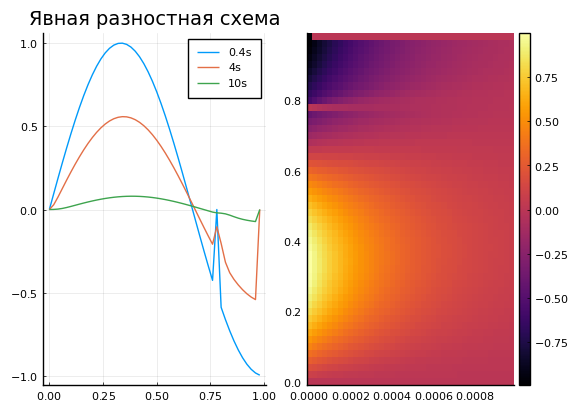

"/Users/dimashestakov/work/study/2022-2023/Математическое моделирование/mathmod/project-group/stage3/explicit_scheme.png"

In [57]:
δ(x) = x==0 ? 0.5 : x>0 ? 1 : 0 # дельта-функция с использованием тернарного оператора
startcond = x-> sin((3*pi*x)/2)# начальное условие
bordrcond = x-> 0 # условие на границе
startcond_N = x->1
D(u) = 1 # коэффициент теплопроводности сосны
τ(n) = 1 # время перераспределения энергии
E = 0.656 # энергия
ΔN(u, n, t) = 0


function linexplicit(Nx = 50, Nt = 40; tlmt = 0.1)
    dx = 1/Nx
    dt = tlmt/Nt
    r = dt/(dx*dx)

    x = [i for i in range(0, length = Nx, step = dx)] 
    t = [i for i in range(0, length = Nt, step = dt)] 
    U = zeros(Nx, Nt)
    N = zeros(Nx, Nt)
    T = zeros(Nx, Nt)
    
    N[:, 1] = startcond_N.(x)

    U[:,1] = startcond.(x)
    U[1,:] = U[Nt,:] = bordrcond.(t)

    for j = 1:Nt-1, i = 2:Nx-1
        U[i, j+1] = U[i,j]*(1-2*r*D( U[i,j] )) + r*U[i-1,j]*D( U[i-1,j] ) 
            + r*U[i+1,j]*D( U[i+1,j]) - ΔN(U[i, j], N[i, j], dt)
        N[i, j+1] = N[i, j] - ΔN(U[i, j], N[i, j], dt)
        T[i, j] = U[1, j] + 0.65*(1/sqrt(4*pi*r*D(U[i, j])*j))*exp(-i^2/(4*r*D(U[i,j])*j))
    end
    t, x, U, N, T
end

t, X, Ans2, N, T = linexplicit( tlmt = 0.001)

plot(X, Ans2[:,1], lab = "0.4s")
plot!(X, Ans2[:,10], lab = "4s")
p = plot!(X, Ans2[:,40], lab = "10s", title = "Явная разностная схема")
plot( p, heatmap(t, X, Ans2))
Plots.savefig("explicit_scheme.png")        

Следующий кусок кода посвящен ***неявной разностной схеме***

Все имеет ровно тот же смысл, только теперь другой способ, с неявной схемой и методом прогонки😄

На графике сравнение получившихся результатов для явной и неявной схем, вроде совпадают🙌

Именования: 
 - non_* = получили из неявной
 - ex_* = получили из явной

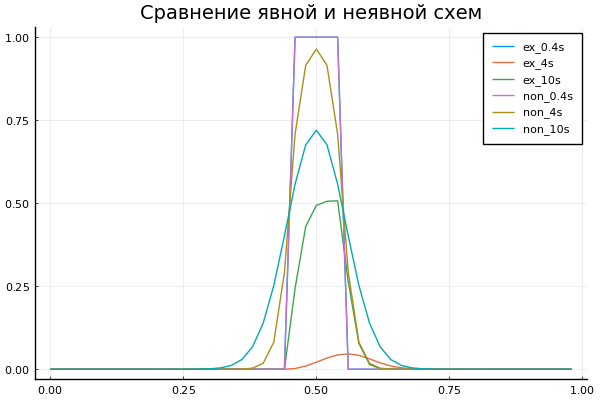

In [6]:
function nonexplicit(Nx = 50, Nt = 40; tlmt = 0.01)
    dx = 1/Nx
    dt = tlmt/Nt
    k = dt/(dx*dx)

    x = [i for i in range(0, length = Nx, step = dx)]
    t = [i for i in range(0, length = Nt, step = dt)]
    U = zeros(Nx, Nt)
    η = zeros(Nx+1)
    ξ = zeros(Nx)

    U[: ,1] = startcond.(x)
    U[1 ,:] = bordrcond.(t)
    U[Nt,:] = bordrcond.(t)

    for j = 1:Nt-1
        b = -1 - 2k*D( U[1,j] )
        c = -k*D( U[2,j] )
        d = U[1,j]
        ξ[2] = c/b
        η[2] = -d/b

        for i = 2:Nx-1

            a = -k*D( U[i-1,j] )
            b = -2k*D( U[i,j] ) - 1
            c = -k*D( U[i+1,j] )
            d = U[i,j]

            ξ[i+1] = c / (b-a*ξ[i])
            η[i+1] = (a*η[i]-d) / (b-a*ξ[i])
        end

        U[Nx,j+1] = η[Nx]

        for i = Nx:-1:2
            U[i-1,j+1] = ξ[i]*U[i,j+1] + η[i]
        end
    end
    t, x, U
end

t1, X1, Ans3 = nonexplicit( tlmt = 10)

plot(X, Ans2[:,1], lab = "ex_0.4s")
plot!(X, Ans2[:,40], lab = "ex_4s")
plot!(X, Ans2[:,10], lab = "ex_10s")
plot!(1X, Ans3[:,1], lab = "non_0.4s")
plot!(X1, Ans3[:,10], lab = "non_4s")
p1 = plot!(X1, Ans3[:,40], lab = "non_10s", title = "Сравнение явной и неявной схем")

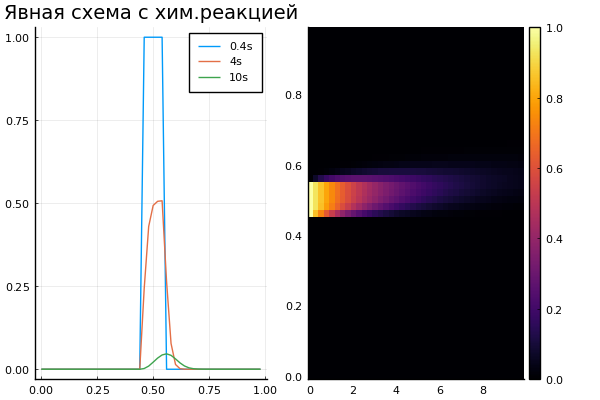

In [7]:
ΔN(u, n, t) = (-n/τ(n)) * exp(-E/u) * t
E = 6
τ(n) = 1

t, X, Ans4, N = linexplicit( tlmt = 10 )

plot(X, Ans4[:,1], lab = "0.4s")
plot!(X, Ans4[:,10], lab = "4s")
p = plot!(X, Ans4[:,40], lab = "10s", title = "Явная схема с хим.реакцией")
plot(p, heatmap(t, X, Ans4))

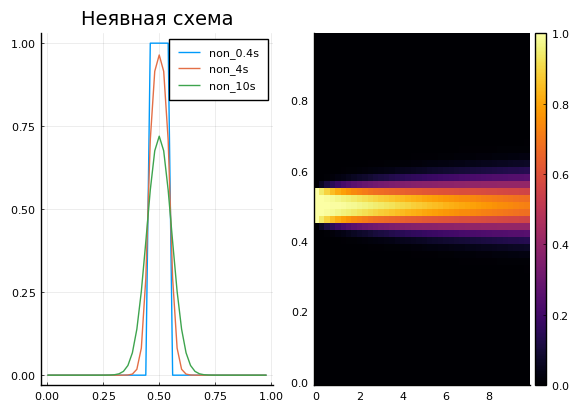

"/Users/dimashestakov/work/study/2022-2023/Математическое моделирование/mathmod/project-group/stage3/implicit_scheme.png"

In [36]:
t2, X2, Ans3 = nonexplicit(tlmt = 10)

plot(X2, Ans3[:,1], lab = "non_0.4s")
plot!(X2, Ans3[:,10], lab = "non_4s")
p1 = plot!(X2, Ans3[:,40], lab = "non_10s", title = "Неявная схема")
plot(p1, heatmap(t2, X2, Ans3))
Plots.savefig("implicit_scheme.png")

Kurant: 31.25 dx = 0.02 dt = 0.0125 k<0.5? false[0.0, 0.000125, 0.00025, 0.000375, 0.0005, 0.000625, 0.00075, 0.000875, 0.001, 0.001125, 0.00125, 0.001375, 0.0015, 0.001625, 0.00175, 0.001875, 0.002, 0.002125, 0.00225, 0.002375, 0.0025, 0.002625, 0.00275, 0.002875, 0.003, 0.003125, 0.00325, 0.003375, 0.0035, 0.003625, 0.00375, 0.003875, 0.004, 0.004125, 0.00425, 0.004375, 0.0045, 0.004625, 0.00475, 0.004875]

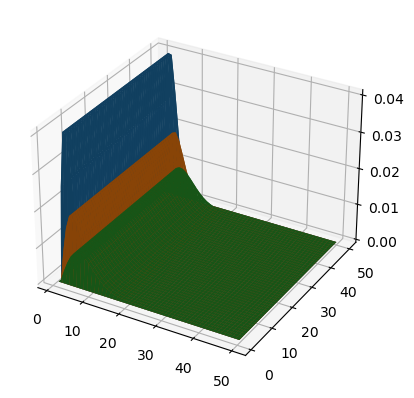

"/Users/dimashestakov/Downloads/stage_3.png"

In [98]:
startcond = x-> sin(3*pi*x/2) # начальное условие
bordrcond = x-> 0. # условие на границе
D(u) =  0.011

function linexplicit1(Nx = 50, Ny = 50, Nt = 40; tlmt = 0.01)
    dx = 1/Nx
    dy = 1/Ny
    dt = tlmt/Nt
    k = dt/(dx*dx)

    x = [i for i in range(0, length = Nx, step = dx)]
    y = [i for i in range(0,length = Ny, step = dy)]
    t = [i for i in range(0, length = Nt, step = dt)]
    U = zeros(Nx,Ny,Nt)
    N = zeros(Nx, Nt)
    
    N[:, 1] = startcond_N.(x)

    for i = 2:Nx-1, y = 2:Ny - 1
        U[i, y, 1] = startcond(i)
    end
    
    U[1,1,:] = U[Nt, Nt, :] .= 0

    for j = 1:Nt-1, i = 2:Nx-1, y = 2:Ny-1
        U[i, y, j+1] = U[i,y,j]*(1-2*k*D( U[i,y,j] )) + k*U[i-1,y,j]*D( U[i-1,y,j] ) + k*U[i+1,y,j]*D( U[i+1,y,j])
             + k*U[i,y-1,j]*D(U[i,y-1,j]) + k*U[i,y+1,j]*D(U[i,y+1,j])- ΔN(U[i, y,j], N[i, j], dt)
         N[i, j+1] = N[i, j] - ΔN(U[i, y,j], N[i, j], dt)
        
    end
    t, x, y, U
end

ΔN(u, n, t) = (-n/τ(n)) * exp(-E/u) * t
E = 6
τ(n) = 1

t, X, Y, Ans_1 = linexplicit1( tlmt = 0.5)

print(t1)

surf(Ans_1[:,:,10])
surf(Ans_1[:,:,20])
surf(Ans_1[:,:,40])

Plots.savefig("~/Downloads/stage_3.png")